In [1]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib  import cm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times New Roman"]})
plt.rcParams["font.family"] = "Times New Roman"

## Generic functions

In [2]:
def add_labels(graph_title, x_label, y_label):
    """
    Add labels to graphs
    """
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

## Papers

[Identifying elastoplastic parameters with Bayes’ theorem considering output error, input error and model uncertainty](https://www.sciencedirect.com/science/article/pii/S0266892018300547)

[A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://link.springer.com/article/10.1007/s11831-018-09311-x)

## Parameters

A linear elastic-perfectly plastic specimen is considered with Young's modulus $E =$ 210 GPa and yield stress $\sigma_{y0} =$ 0.25 GPa. 

The parameters to be identified for the linear elastic-perfectly plastic model are the Young's modulus and the initial yield stress, which are stored in the parameter vector $\textbf{x}$:

 $$\textbf{x}=[E \; \sigma_{y0}]^T$$

In [3]:
E_correct = 210              # Young's modulus (GPa)
yield_stress_correct = 0.25  # Yield stress (GPa)
s_noise_correct = 0.01       # Noise in the stress measurement (GPa)

## Constitutive model

The stress-strain response of the linear elastic-perfectly plastic model during monotonic tension can be written as:

$$\sigma(\epsilon, \textbf{x}) = 
    \begin{cases}
        E\epsilon \quad \text{if} \quad \epsilon \leqslant \frac{\sigma_{y0}}{E} \\
        \sigma_{y0} \quad \text{if} \quad \epsilon > \frac{\sigma_{y0}}{E}
    \end{cases}$$

Using the Heaviside step function $h$, the stress-strain response of the linear elastic-perfectly plastic model can alternatively be expressed as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) + \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)$$

Where $\textbf{x}$ is the parameter vector:

$$\textbf{x} = [E \; \sigma_{y0}]^T$$

$E$ is the Young's modulus and $\sigma_{y0}$ is the initial yield stress.

In [4]:
def calculate_stress(strain, yield_stress, E):
    yield_strain = yield_stress / E
    if strain < yield_strain:
        stress = E * strain
    elif strain > yield_strain:
        stress = yield_stress
    return stress

### Stress-strain graph

Twelve experimental measurements are provided. The noise $\Omega$ in the stress measurements is a normal distribution with a zero mean and a standard deviation of $s_{noise}$.

In [5]:
def plot_stress_strain(strain_measured, stress_measured, yield_stress, E):
    
    strain = numpy.linspace(0, 2.5E-3, 100)
    stress = []

    for i in range(len(strain)):
        tmp = calculate_stress(strain[i], yield_stress, E)
        stress.append(tmp)
    
    plt.plot(strain, stress)
    plt.plot(strain_measured, stress_measured, 'o')
    add_labels("Stress-strain graph", "Strain $\epsilon$", "Stress $\sigma$")

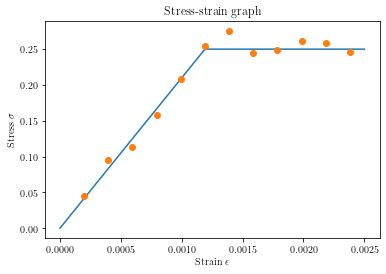

In [6]:
strain_experimental = [0.198E-3, 0.397E-3, 0.595E-3, 0.793E-3, 0.992E-3, 1.190E-3, 
                       1.388E-3, 1.587E-3, 1.785E-3, 1.985E-3, 2.182E-3, 2.383E-3]
stress_experimental = [0.0448, 0.0955, 0.113, 0.158, 0.209, 0.255, 
                       0.276, 0.244, 0.249, 0.262, 0.259, 0.246]
plot_stress_strain(strain_experimental, stress_experimental, yield_stress_correct, E_correct)

## Likelihood

$$\pi(y|\textbf{x}) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-{\frac{\left(y - E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)$$

## Prior

$$\pi(\textbf{x}) = exp\left(-\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} \right)$$

The following mean vector (prior candidate vector) and convariance matrix are selected:

$$\overline{\textbf{x}} = \begin{bmatrix} 200 \\ 0.29 \end{bmatrix} \; \text{GPa}, \quad \Gamma_\textbf{x} = \begin{bmatrix} 2500 & 0 \\ 0 & 2.7778 \times 10^{-4} \end{bmatrix} \; \text{GPa}^2$$

In [7]:
def calculate_prior(candidate_x, prior_x, cov_matrix):
    """
    Calculate the prior - note the exponential of the prior is taken
                          when calculating the posterior
    """
    temp_var = candidate_x - prior_x
    inv_cov_matrix = numpy.linalg.inv(cov_matrix)
    numerator = numpy.matmul(numpy.transpose(temp_var), numpy.matmul(inv_cov_matrix, temp_var))
    prior = numerator / 2
    return prior

## Posterior

$$\pi(\textbf{x}|\textbf{y}) = exp\left(-\left(\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} + {\frac{\Sigma_{i=1}^{n_m}\left(y_i - E\epsilon_i\left(1 - h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)\right)$$

Where $n_m$ is the number of measurements, $y_i$ is the measured stress and $\epsilon_i$ is the measured strain.

In [8]:
def calculate_posterior(candidate_x, prior_x, cov_matrix,
                        strain_measured, stress_measured, s_noise):
        
    prior = calculate_prior(candidate_x, prior_x, cov_matrix)
    
    candidate_yield_stress = candidate_x[1]
    candidate_E = candidate_x[0]
    
    total = 0
    for i in range(len(stress_measured)):  # Loop over experimental data
        total += (stress_measured[i] - calculate_stress(strain_measured[i], candidate_yield_stress, candidate_E))**2
    
    posterior = numpy.exp(-(prior + (total / (2 * s_noise**2))))

    return posterior

## The standard Metropolis-Hastings algorithm

The standard Metropolis-Hastings approach is a frequently employed MCMC algorithm. The basic idea of the Metropolis-Hastings algorithm is to explore the probability density function (PDF) of interest by making a random walk through the parameter space $\textbf{x}$.

Consider sample $\textbf{x}_i$ and its evaluation of the PDF, $\pi(\textbf{x}_i)$ new sample $\textbf{x}_p$ is proposed by drawing from a proposal distribution.

$\gamma$ denotes the parameter that determines the width of the proposal distribution and must be tuned to obtain an efficient and converging algorithm. An efficient starting value is given by the following equation [1]:

$$\gamma = \frac{2.38}{\sqrt{n_p}}$$

Where $n_p$ denotes the number of unknown parameters.

[1] Gelman A, Roberts GO, Gilks WR (1996) Efficient Metropolis jumping rules. In: Bernardo JM, Berger JO, Dawid AP, Smith AFM (eds) Bayesian Statistics, vol 5. Oxford University Press, pp 599-607

### Proposal distribution

New sample $\textbf{x}_p$ is proposed by drawing from a proposal distribution $q(\textbf{x}_i | \textbf{x}_p)$... << is this correct?

In the case of a symmetric proposal distribution (as in this example), the following relation holds:

$$q(\textbf{x}_i | \textbf{x}_p) = q(\textbf{x}_p | \textbf{x}_i)$$

In [9]:
def propose_new_sample(current_x):
    """
    Draw x (candidate) from proposal distribution
    """
    
    gamma = [[5], [0.1]] / numpy.sqrt(len(current_x))
    candidate_x = current_x + (gamma * numpy.transpose(numpy.random.normal(size=(1,2))))
    
    return candidate_x

In [10]:
def accept_or_reject_candidate(sample, current_x, candidate_x, pdf_candidate_x, pdf_current_x,
                               history_x, history_pdf, n_accept):
    
    # Calculate the acceptance ratio (alpha) - alpha is used to decide whether to accept or reject a candidate
    alpha = min(1, pdf_candidate_x / pdf_current_x)

    # Generate a uniform random number (u)
    u = numpy.random.uniform(low=0.0, high=1.0)

    # Accept if u < alpha
    if u < alpha:
        history_x[sample, :] = numpy.transpose(candidate_x)
        current_x = candidate_x
        history_pdf[sample] = pdf_candidate_x
        n_accept += 1

    # Reject if u > alpha
    if u > alpha:
        history_x[sample, :] = numpy.transpose(current_x)
        history_pdf[sample] = pdf_current_x
        
    return current_x, history_x, history_pdf, n_accept

In [11]:
def metropolis_hastings(initial_x, prior_cov_matrix, 
                        strain_measured, stress_measured, 
                        s_noise, n_samples=100000):
    """
    Standard Metropolis-Hastings algorithm
    
    Parameters
    ----------
    initial_x : ndarray
        Initial array of parameters (mean vector)
    prior_cov_matrix : ndarray
        Covariance matrix
    strain_measured : list
        Experimental strain data
    stress_measured : list
        Experimental stress data
    s_noise : float
        The PDF of the noise in the stress measurements is a normal distribution 
        with a zero mean and a standard deviation of s_noise
    n_samples : int
        Number of samples (default value is 100,000)


    Returns
    -------
    history_x : ndarray
        Parameter chain
    history_pdf : ndarray
        Probability density of every sample
    acceptance_rate : ndarray
        Acceptance rate
    lnprob : ndarray
        log-posterior chain

    Notes
    -----

    """

    dim = len(initial_x)  # Number of dimensions (Young's modulus, yield stress)
    
    # Initial candidate
    current_x = initial_x.copy()
    prior_x = initial_x.copy()
    
    # Initialise chain    
    history_pdf = numpy.zeros(n_samples)
    history_x = numpy.zeros([n_samples, dim])
    accept_rate = numpy.zeros(n_samples)
    lnprob = numpy.zeros(n_samples)
    
    # First samples    
    history_x[0, :] = numpy.transpose(current_x)

    # Start loop    
    n_accept = 0  # Number of accepted samples    
    for i in range(1, n_samples):
        
        # Draw a candidate from the proposal distribution
        candidate_x = propose_new_sample(current_x)

        # Calculate the likelihood        
        pdf_current_x = calculate_posterior(current_x, prior_x, prior_cov_matrix, 
                                            strain_measured, stress_measured, s_noise)

        pdf_candidate_x = calculate_posterior(candidate_x, prior_x, prior_cov_matrix, 
                                              strain_measured, stress_measured, s_noise)
        
        # Accept or reject the candidate        
        current_x, history_x, history_pdf, n_accept = accept_or_reject_candidate(i, current_x, candidate_x, 
                                                                                 pdf_candidate_x, pdf_current_x,
                                                                                 history_x, history_pdf, n_accept)
        
        # Update chain        
        accept_rate[i] = n_accept / i
            
    return history_x, history_pdf, accept_rate

## Markov Chain Monte Carlo

Determine the PDF for the Young's modulus $E$ and yield stress $\sigma_{y0}$

In [12]:
n_burnt_samples = 3000

initial_x = numpy.array([[200], [0.29]])  # Mean vector (GPa)
cov_matrix = numpy.array([[2500, 0], [0, 2.7778E-4]])  # Covariance matrix (GPa^2)

x, pdf, acc_rate = metropolis_hastings(initial_x, cov_matrix, strain_experimental, stress_experimental, 
                             s_noise_correct)


### Convergence

A commonly employed approach to check the stability and convergence of the scheme is to trace the generated samples and analyse their characteristics.

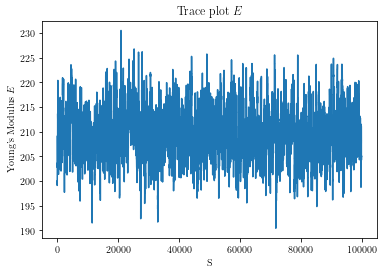

In [13]:
plt.plot(x[:,0])
add_labels("Trace plot \(E\)", "S", "Young's Modulus \(E\)")

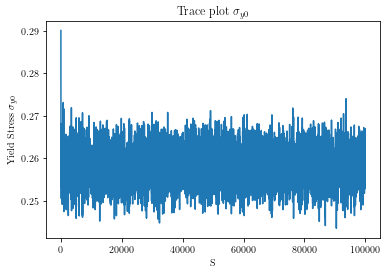

In [14]:
plt.plot(x[:,1])
add_labels("Trace plot \(\sigma_{y0}\)", "S", "Yield Stress \(\sigma_{y0}\)")

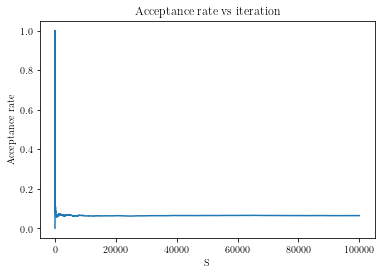

In [15]:
plt.plot(acc_rate)
add_labels("Acceptance rate vs iteration", "S", "Acceptance rate")

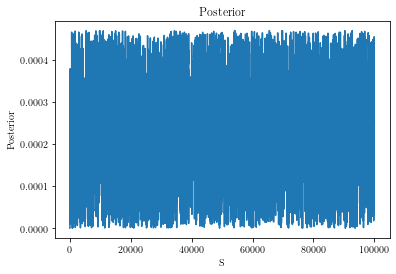

In [16]:
plt.plot(pdf)
add_labels("Posterior", "S", "Posterior")

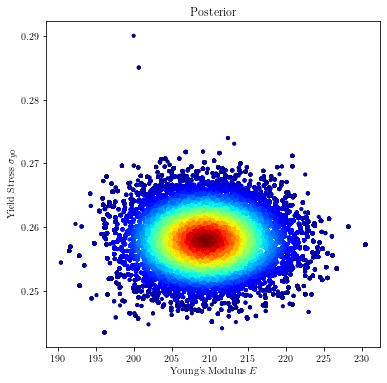

In [20]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(x[:,0], x[:,1], s=10, c=pdf, marker = 'o', cmap = cm.jet );
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
fig.savefig('posterior.png', dpi=300) 

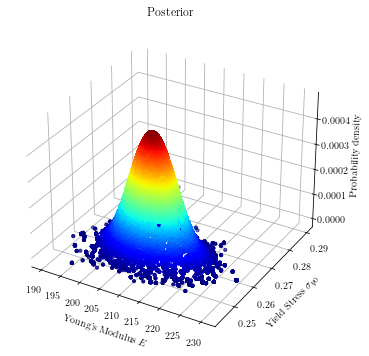

In [33]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], pdf, s=10, c=pdf, marker = 'o', cmap = cm.jet );
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
ax.set_zlabel('Probability density')

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

fig.savefig('posterior_3D.png', dpi=300) 

## The Adaptive Metropolis-Hastings algorithm


The width of the proposal distribution $\gamma$ has to be tuned to obtain an efficient and converging algorithm. It can be seen in the above figures that the chain converges on the correct yield stress $\sigma_{y0}$ but poor convergence behaviour is observed for the Young's modulus $E$. To overcome the tuning of $\gamma$, Haario et al. [2] introduced the adaptive proposal (AP) method. The AP method updates the width of the proposal distribution using the existing knowledge of the posterior. The existing knowledge is based on the previous samples.

For sample $n_k + 1$, the update employs the following formulation:

$$q(\textbf{x}_p | \textbf{x}_i) \sim \mathcal{N}(\textbf{x}_i, \gamma^2 \textbf{R}_{n_{\textbf{k}}})$$

Where $\mathcal{N}(\textbf{x}_i, \gamma^2 \textbf{R}_{n_{\textbf{k}}})$ denotes a normal distribution with mean $\textbf{x}_i$ and covariance matrix $\gamma^2 \textbf{R}_{n_{\textbf{k}}}$ of size $n_p \times n_p$. To establish $\textbf{R}_{n_{\textbf{k}}}$, all $n_k$ previous samples are first stored in matrix $\textbf{K}$ of size $n_{\textbf{K}} \times n_p$. $\textbf{R}_{n_{\textbf{k}}}$ is then computed as:

$$\textbf{R}_{n_{\textbf{k}}} = \frac{1}{n_{\textbf{K}} - 1}\tilde{\textbf{K}}^T\tilde{\textbf{K}}$$

Where $\tilde{\textbf{K}} = \textbf{K} - \textbf{K}_{mean}$ and $\textbf{K}_{mean}$ reads:

$$\textbf{K}_{mean} =
\begin{bmatrix}
   \textbf{k}_{mean} \\
   \textbf{k}_{mean}  \\
   \vdots \\
   \textbf{k}_{mean} 
\end{bmatrix}_{\: n_\textbf{K} \, \times \, n_p}
$$

and $\textbf{K}_{mean}$ denotes a row matrix (vector?) of length $n_p$ (number of unknow parameters) which is determined as follows:

$$\textbf{k}_{mean} = \frac{1}{i}\begin{bmatrix} \sum_{i=1}^{n_\textbf{K}} (K)_{i1} & \sum_{i=1}^{n_\textbf{K}} (K)_{i2} & \cdots & \sum_{i=1}^{n_\textbf{K}} (K)_{in_p} \end{bmatrix}$$

The following relation is used for $\mathcal{N}(\textbf{x}_i, \gamma^2 \textbf{R}_{n_{\textbf{k}}})$ in this contribution:


[2] Haario, H., Saksman, E., & Tamminen, J. (1999). Adaptive proposal distribution for random walk Metropolis algorithm. Computational Statistics, 14(3), 375-395.

In [18]:
def adaptive_metropolis_hastings():
    """
    Adaptive Metropolis-Hastings algorithm
    
    Parameters
    ----------
    K : ndarray
        Array of previous samples (no of samples, no of unknown parameters)
    
    Returns
    -------

    Notes
    -----
    """
    
    # Start loop
    
        # Draw a candidate from the proposal distribution
        
        # Calculate the likelihood
        
        # Accept or reject the candidate
        
        # Update chain
        
        # Update matrix K
    
    pass

In [19]:
def update_matrix_K():
    # TODO: K is essentially the chain of samples?
    pass